In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from scipy.stats import normaltest
from scipy.special import factorial
from scipy.linalg import solve, det
from functools import reduce

In [211]:
!pip install -q sociophysicsDataHandler 
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()
p = """guest
YDPGL-XREXC-QGMZS-UAKES"""
c = """text_file = open("auth.txt", "w+");text_file.write(p);text_file.close()""" 
exec(c)

In [95]:
df = pd.read_csv('CompressedData ehv all multibin.csv')
#df['hour'] = pd.to_datetime(df['Unnamed: 0']*10**6).dt.hour
for index in df.columns[4:]:
    df[index] = df[index]/df['N']
    
df = df.drop(['p_left', 'p_right'], axis=1).drop(['1, 2', '1, 3'], axis=1)

df

,Unnamed: 0,N,"0, 0","1, 0","2, 0","0, 1","1, 1","2, 1","0, 2","2, 2","0, 3","2, 3","0, 4","1, 4","2, 4","0, 5","1, 5","2, 5"
0,1.617093e+12,34,0.058824,0.147059,0.029412,0.029412,0.088235,0.058824,0.088235,0.117647,0.058824,0.000000,0.029412,0.000000,0.029412,0.117647,0.000000,0.000000
1,1.617093e+12,16,0.250000,0.000000,0.187500,0.000000,0.125000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000
2,1.617093e+12,27,0.037037,0.074074,0.074074,0.000000,0.111111,0.074074,0.185185,0.222222,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.037037
3,1.617093e+12,29,0.000000,0.068966,0.103448,0.000000,0.137931,0.068966,0.000000,0.103448,0.000000,0.172414,0.000000,0.103448,0.034483,0.000000,0.000000,0.034483
4,1.617093e+12,38,0.000000,0.131579,0.052632,0.026316,0.078947,0.105263,0.026316,0.105263,0.000000,0.131579,0.000000,0.157895,0.052632,0.000000,0.000000,0.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175634,1.668380e+12,17,0.000000,0.117647,0.117647,0.000000,0.470588,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.176471,0.000000,0.000000,0.058824,0.000000
175635,1.668380e+12,18,0.000000,0.111111,0.166667,0.055556,0.444444,0.055556,0.000000,0.055556,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000
175636,1.668380e+12,24,0.000000,0.125000,0.000000,0.041667,0.416667,0.125000,0.000000,0.166667,0.000000,0.041667,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000
175637,1.668380e+12,39,0.000000,0.153846,0.051282,0.051282,0.282051,0.230769,0.000000,0.076923,0.000000,0.000000,0.000000,0.076923,0.025641,0.000000,0.000000,0.000000


{0.0: 0.19636497410583642,
 0.05: 0.060445292197843795,
 0.1: -0.9020773978161343,
 0.15: -2.1753780702603867,
 0.2: -3.634652786011318,
 0.25: -5.173470134824279,
 0.3: -7.158298576826545,
 0.35: -9.069072185869299,
 0.4: -10.748394614114359,
 0.45: -13.77357645263013,
 0.5: -15.545895486434512,
 0.55: -19.013925719772253,
 0.6: -20.110548843773888,
 0.65: -24.81920507495964,
 0.75: -31.600307797020857,
 0.8: -35.08989411493251}

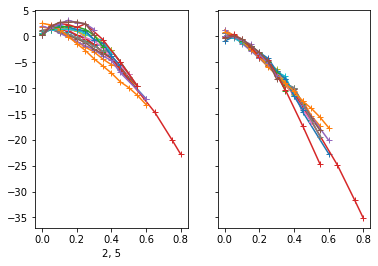

In [254]:
n = 20

l = df[df['N']==n]['0, 0'].count()
mn = (df[df['N'] == n]['0, 0']*n).mean()

#ax1 = (df[df['N'] == n]['p_right']*n).hist(bins=10)

trs = []
xs = []
for index in df.columns[2:]:
    pb = (df[df['N'] == n]).groupby(index).count()['N']/l

    x = df[df['N'] == n].groupby(index).count().index
    xs.append(x)
    
    tr = -np.log(factorial(x*n)*pb[x])
    trs.append(tr)

M = generate_matrix(len(xs), xs)
f = generate_f(trs, xs)

sol = solve(M.T*M, M.T*f)

df_sol = pd.DataFrame(index=df.columns[2:], columns=['v', 'z'])

df_sol['v'] = sol[::2]
df_sol['z'] = sol[1::2]



fig, ax = plt.subplots(1, 2, sharey=True)

frs = []

for i in range(len(trs)):
    trs[i].plot(ax=ax[0], marker='+')
    
    frs.append(trs[i] - sol[2*i, 0]*xs[i] - sol[2*i+1, 0])
    
    ax[1].plot(xs[i], (trs[i] - sol[2*i, 0]*xs[i] - sol[2*i+1, 0]), '-+')
    
pd.concat(frs, axis=1).mean(axis=1).to_dict()

In [204]:
def generate_matrix(m, xs):

# system:
# (v1 - v2) x(n) + (z1 - z2) = f1(n) - f2(n), for n = 0, 1, 2, 3, 4, 5, ..
# (v2 - v3) x(n) + (z2 - z3) = f2(n) - f3(n), for n = 0, 1, 2, 3, 4, 5, ..
# ..
# (v_{m-1} - v_m) x(n) + (z_{m-1} - z_m) = f_{m-1}(n) - f_m(n)
# z1 = f1(0)
# v1 x(1) + z1 = f1(1)
    Ms = []

    for i in range(m-1):
        x = np.intersect1d(xs[i], xs[i+1])
        
        M_i = np.matrix(np.zeros((len(x), m*2)))

        mask = np.matrix([[((j >= i*2) and (j < i*2 + 4)) for j in range(m*2)] for _ in x])
        
        values = np.matrix([[xt, 1, -xt, -1] for xt in x])

        np.place(M_i, mask, values)

        Ms.append(M_i)

    Mcond = np.matrix(np.zeros((2, m*2)))
    Mcond[0, 1] = 1
    #Mcond[1, 2:4] = [1, 1]
    Mcond[1, 0] = 1

    Ms.append(Mcond)

    return np.concatenate(Ms)

def generate_f(trs, xs):
    fs = []
    
    for i in range(len(trs)-1):
        x = np.intersect1d(xs[i], xs[i+1])
        fs.append(trs[i][x].to_numpy().reshape(len(trs[i][x]), 1) - trs[i+1][x].to_numpy().reshape(len(trs[i+1][x]), 1))
        
    fcond = np.array([[trs[0][0]],
                      [(trs[0].iloc[1] - trs[0].iloc[0])/(x[1]-x[0])]])
    #                  [trs[1].iloc[1]]])
    
    fs.append(fcond)
        
    return np.concatenate(fs)

M = generate_matrix(len(xs), xs)
f = generate_f(trs, xs)

M.shape, f.shape

((133, 32), (133, 1))

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg


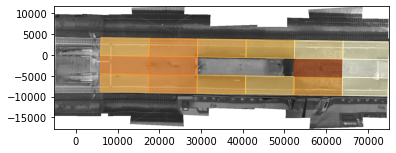

In [223]:
df_geometry = pd.read_csv('Geometry ehv all multibin.csv').set_index('Unnamed: 0')

cmap = mpl.cm.get_cmap('YlOrBr')

for i in df_geometry.index:

    x = [list(eval(a))[0] for a in df_geometry.loc[i].to_list()]
    y = [list(eval(a))[1] for a in df_geometry.loc[i].to_list()]

    try:
        plt.fill(x, y, color=cmap(-df_sol['v'][i]/df_sol['v'].min()+1), alpha=0.6)
    except:
        pass
    
dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')
image = dh.bg

plt.imshow(image, extent=[-5134, 75135, -17731, 11645])

In [255]:
df_sol['v'].to_list()

[16.60696604146862,
 12.944484812466825,
 17.489381735841153,
 14.339951913437485,
 11.925207615767174,
 14.627772095404278,
 17.120767281180843,
 17.138640295294696,
 19.776016407244143,
 18.423644358238306,
 16.51434180129866,
 4.548416657177142,
 23.43020056494674,
 26.804885740319435,
 29.428316451019896,
 26.654578981808378]

In [246]:
pd.concat([trs[1] - sol[2*1, 0]*xs[1] - sol[2*1+1, 0], trs[2] - sol[2*2, 0]*xs[2] - sol[2*2+1, 0]], axis=1)

,0,1
0.00,-1.266785,-0.729855
0.05,-0.223398,-0.172962
0.10,1.057614,1.004927
0.15,2.529448,2.534137
0.20,4.168313,4.111232
0.25,5.914149,5.620579
0.30,7.471192,7.082835
0.35,9.481721,9.410738
0.40,11.219775,9.966753
0.45,12.390248,13.038447
